- Generate relatively balanced/hybrid dataset and balanced dataset, call Ollama3 api to answer the question.
- Based on the two csv files, calculate the relation-wise performance of ollama3-70B.

In [ ]:
import pandas as pd
import numpy as np
import litellm
from litellm import completion
import time 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

os.environ['GROQ_API_KEY'] = "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"
os.environ['DEEPSEEK_API_KEY'] = "sk-1b22df9504bb4de8b0ecab4af9736a43"
os.environ['LLAMA_API_KEY']= "LL-NvPlk1hPGRjLyA7SFKVQYghNwI8HZujwnk4FEgUf9YEW9wI1c7Vc3szQUPDbryQ0"


In [ ]:
# Load your dataset
df = pd.read_csv('Spartun/test.csv')
print(len(df))
relations = df['target_relation'].unique()
# Get the unique relations and their counts
relation_counts = df['target_relation'].value_counts()
# Create a dictionary of relations
relation_dict = relation_counts.to_dict()
# Print the relation dictionary
print("Relation Dictionary",relation_dict)
relation_distribution = df['target_relation'].value_counts() 

# Define custom colors for the bars
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(12, 8))
relation_distribution.plot(kind='bar', color=custom_colors)
plt.title('Distribution of target_relation types in Spartun', fontsize=14, fontweight='bold')
plt.xlabel('Relation Types', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add grid lines
plt.tight_layout()

plt.savefig('relation_distribution_plot.png', dpi=300)  # Save the plot with higher resolution
plt.show()

In [ ]:

def create_hybrid_test_set(file_path, min_threshold=150, mid_threshold=200, max_threshold=400):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Count occurrences of each relation
    relation_counts = df['target_relation'].value_counts()
    
    # Identify relations based on count ranges
    rare_relations = relation_counts[relation_counts < min_threshold]
    common_relations_1 = relation_counts[(relation_counts >= min_threshold) & (relation_counts < mid_threshold)]
    common_relations_2 = relation_counts[(relation_counts >= mid_threshold) & (relation_counts < max_threshold)]
    common_relations_3 = relation_counts[relation_counts >= max_threshold]
    
    # Create a new DataFrame to store the hybrid dataset
    hybrid_df = pd.DataFrame(columns=df.columns)
    
    # Process rare relations (duplicate to 150)
    for relation, count in rare_relations.items():
        relation_df = df[df['target_relation'] == relation]
        #additional_needed = min_threshold - count
        additional_rows = relation_df.sample(n=100, replace=True)
        hybrid_df = pd.concat([hybrid_df, relation_df, additional_rows])
    
    # Process common relations (140 <= count < 200)
    for relation in common_relations_1.index:
        relation_df = df[df['target_relation'] == relation]
        hybrid_df = pd.concat([hybrid_df, relation_df])
    
    # Process common relations (200 <= count < 400, sample to 200)
    for relation in common_relations_2.index:
        relation_df = df[df['target_relation'] == relation]
        sampled_rows = relation_df.sample(n=200, replace=False)
        hybrid_df = pd.concat([hybrid_df, sampled_rows])
    
    # Process very common relations (count >= 400, sample to 300)
    for relation in common_relations_3.index:
        relation_df = df[df['target_relation'] == relation]
        sampled_rows = relation_df.sample(n=200, replace=False)
        hybrid_df = pd.concat([hybrid_df, sampled_rows])
    
    # Shuffle the DataFrame
    hybrid_df = hybrid_df.sample(frac=1).reset_index(drop=True)
    
    return hybrid_df


# Usage
hybrid_dataset = create_hybrid_test_set('Spartun/test.csv', min_threshold=140, mid_threshold=200, max_threshold=500)
print(len(hybrid_dataset))
# If you want to save the hybrid dataset
hybrid_dataset.to_csv('Spartun/hybrid_test.csv', index=False)
# Print the distribution
relation_distribution = hybrid_dataset['target_relation'].value_counts(normalize=True)
# Print the distribution
print("Distribution of target_relation:")
for relation, percentage in relation_distribution.items():
    count = hybrid_dataset['target_relation'].value_counts()[relation]
    print(f"{relation}: {count} ({percentage:.2%})")


plt.figure(figsize=(10, 6))
relation_distribution.plot(kind='bar')
plt.title('Distribution of target_relation in Spartun hybrid balanced dataset')
plt.xlabel('Relation')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv('Spartun/test.csv')
unique_relations = df['target_relation'].unique()
# Initialize an empty list to store the processed dataframes
processed_dfs = []
n_samples= 300
for relation in unique_relations:
    # Filter the dataset for the current relation
    relation_df = df[df['target_relation'] == relation]
    # Randomly sample the dataframe
    if len(relation_df) > n_samples:
        relation_df = relation_df.sample(n=150, random_state=100)
    elif len(relation_df) < n_samples:
        relation_df = relation_df.sample(n=120, replace=True, random_state=100)
    # Append the processed dataframe to the list
    processed_dfs.append(relation_df)
    
# Concatenate all processed dataframes
result_df = pd.concat(processed_dfs, ignore_index=True)
result_df = result_df.sample(frac=1, random_state=800).reset_index(drop=True)
# Shuffle the final dataframe to mix the relations
print(len(result_df))
result_df.to_csv('Spartun/test_balanced.csv', index=False)


relation_vocabulary = {
    "LEFT": ["left", "west"],
    "RIGHT": ["right", "east"],
    "ABOVE": ["above", "over","north"],
    "BELOW": ["below", "under", "south"],
    "BEHIND": ["behind", "back"],
    "FRONT": ["front", "in front of"],
    "NEAR": ["near", "close to", "near to"],
    "FAR": ["far", "far from", "away from"],
    "DC": ["disconnected", "disconnected from"],
    "EC": ["touch", "touching"],
    "PO": ["overlap", "overlaps", "overlapping"],
    "NTPP": ["in", "inside", "within"],
    "NTPPI": ["has", "have", "having", "contains", "containing"],
    "TPP": ["covered by", "inside and touching", "touching", "in", "inside", "within"],
    "TPPI": ["cover", "covers", "covering", "touching", "having", "containing"]}

In [ ]:

#litellm.set_verbose=True
system_prompt = """
You are an expert in spatial reasoning with a focus on topological relationships. When answering questions, think through each step carefully before providing your final response.
For questions about spatial relations, consider directional, distance, and RCC-8 (Region Connection Calculus) relations. The possible RCC-8 relations are:
- DC (Disconnected)- EC (Externally Connected)- PO (Partially Overlapping)- NTPP (Non-Tangential Proper Part)
- NTPPI (Non-Tangential Proper Part Inverse)- TPP (Tangential Proper Part)- TPPI (Tangential Proper Part Inverse)- EQ (Equal)
Important instructions:
1. Select only the answer(s) that are provided in the given choices for each question.
2. If multiple answers apply, list all relevant choices, including the distance relations, directional relations, and RCC relations.
3. Provide only the selected answer(s) without any additional explanation or reasoning.

Remember to analyze the spatial scenario thoroughly before making your selection.
"""

# Set your Groq API key
os.environ['GROQ_API_KEY'] = "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"
df = pd.read_csv('Spartun/hybrid_test.csv')

# Load your dataset

# Define the model you want to evaluate
model = "groq/llama3-70b-8192"  # Make sure this is the correct model name for Groq

# Prepare the system prompt

def process_question(row):
    context = row["story"]
    question = row["question"]
    choices = row["choices"]
    user_prompt = f"Context: {context}\nQuestion: {question}\nPlease choose the answer(s)from the choices.\nChoices: {choices} "
    try:
        response = completion(
            model=model,
            messages=[
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_prompt}
            ],
            max_tokens=1000,
            top_p=0.9,
            temperature=0.1,
            num_retries=3,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error processing question: {e}")
        return "ERROR: Unable to get response"


# Process all questions
start_time = time.time()

  # Apply the process_question function
result_df['model_answer'] = result_df.apply(process_question, axis=1)
# You can now use result_df for further processing or analysis 
end_time = time.time()

print(f"Time taken for all questions: {end_time - start_time:.2f} seconds")
result_df.to_csv('llama3_relations_hybrid.csv', index=False)

Relation-wise Accuracies for balanced dataset:
target_relation
po        0.848437
ec        0.714000
near      0.690000
below     0.671000
above     0.659000
far       0.643000
ntpp      0.621000
tpp       0.611000
dc        0.606000
left      0.552000
ntppi     0.550000
right     0.548000
tppi      0.538000
front     0.525000
behind    0.479000
dtype: float64
Relation-wise Accuracies for real-world dataset:
target_relation
po        0.861224
near      0.707547
above     0.706186
far       0.700000
ntpp      0.681609
below     0.662000
ec        0.635616
tpp       0.621429
right     0.608000
dc        0.601429
front     0.595082
ntppi     0.589535
tppi      0.555556
behind    0.483077
left      0.462195
dtype: float64


/var/folders/zg/pvlsm7s116zd61_5k5qx9hkr0000gn/T/ipykernel_34236/2964548818.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  relation_accuracy_1 = result_df_1.groupby('target_relation').apply(accuracy).sort_values(ascending=False)
/var/folders/zg/pvlsm7s116zd61_5k5qx9hkr0000gn/T/ipykernel_34236/2964548818.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  relation_accuracy_2 = result_df_2.groupby('tar

<Figure size 1500x1000 with 0 Axes>

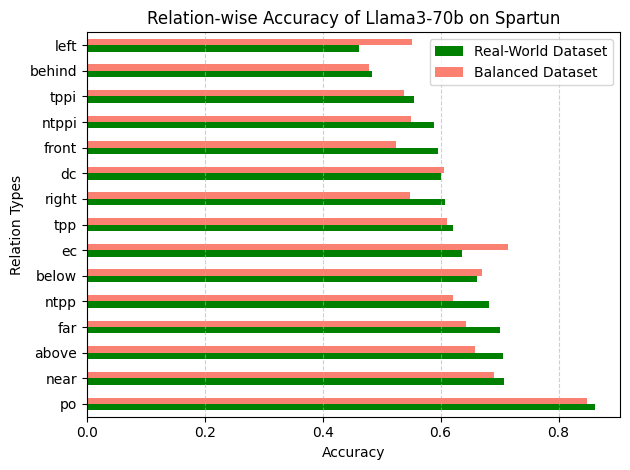


Overall Accuracy for 1: 0.53

Overall Accuracy for 2: 0.55


In [106]:

# Calculate accuracy for each relation

def accuracy(df):
    correct = 0
    true_answers= df["answer"]
    pred_answers =df["model_answer"]
    total = len(true_answers)
    for true, pred in zip(true_answers, pred_answers):
        if pd.isna(true) or pd.isna(pred):
            total -= 1  # Skip this pair if either is NaN
            continue
        true_set = set(map(str.lower, true))  # Convert true answers to lowercase
        pred_set = set(map(str.lower, pred)) 
        if len(true_set) > 1:  # Multiple correct answers
            if true_set == pred_set:
                correct += 1  # Full match
            elif true_set.intersection(pred_set):
                 correct += 0.3  # Partial match
        else:  # Single correct answer
            if true_set == pred_set:
                correct += 1
    
    return correct / total if total > 0 else 0


df_1 = pd.read_csv('llama3_relations_balanced.csv')
df_2 = pd.read_csv('llama3_relations_hybrid.csv')

result_df_1= df_1.sample(frac=1, random_state=88)
relation_accuracy_1 = result_df_1.groupby('target_relation').apply(accuracy).sort_values(ascending=False)

result_df_2= df_2.sample(frac=1, random_state=9)
relation_accuracy_2 = result_df_2.groupby('target_relation').apply(accuracy).sort_values(ascending=False)

# Print the accuracies
print("Relation-wise Accuracies for balanced dataset:")
print(relation_accuracy_1)
print("Relation-wise Accuracies for real-world dataset:")
print(relation_accuracy_2)


combined_accuracy = pd.concat([ relation_accuracy_2,relation_accuracy_1,], axis=1)
combined_accuracy.columns = ['Real-World Dataset','Balanced Dataset',]

# Create a horizontal bar plot with grid lines
plt.figure(figsize=(15, 10))
combined_accuracy.plot(kind='barh', color=['green', 'salmon'])
plt.title("Relation-wise Accuracy of Llama3-70b on Spartun")
plt.xlabel('Accuracy')
plt.ylabel('Relation Types')
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add grid lines on the x-axis
plt.tight_layout()

plt.show()
# Calculate and print overall accuracy
overall_accuracy = (result_df_1['answer'].str.lower().str.strip() == result_df_1['model_answer'].str.lower().str.strip()).mean()
print(f"\nOverall Accuracy for 1: {overall_accuracy:.2f}")
overall_accuracy = (result_df_2['answer'].str.lower().str.strip() == result_df_2['model_answer'].str.lower().str.strip()).mean()
print(f"\nOverall Accuracy for 2: {overall_accuracy:.2f}")



/var/folders/zg/pvlsm7s116zd61_5k5qx9hkr0000gn/T/ipykernel_34236/571822675.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reasoing_steps_accuracy = result_df_2.groupby('reasoning_steps').apply(accuracy)


reasoning steps-wise Accuracies:
reasoning_steps
1    0.662154
2    0.559690
3    0.564964
4    0.596591
5    0.567391
6    0.790000
7    0.300000
dtype: float64


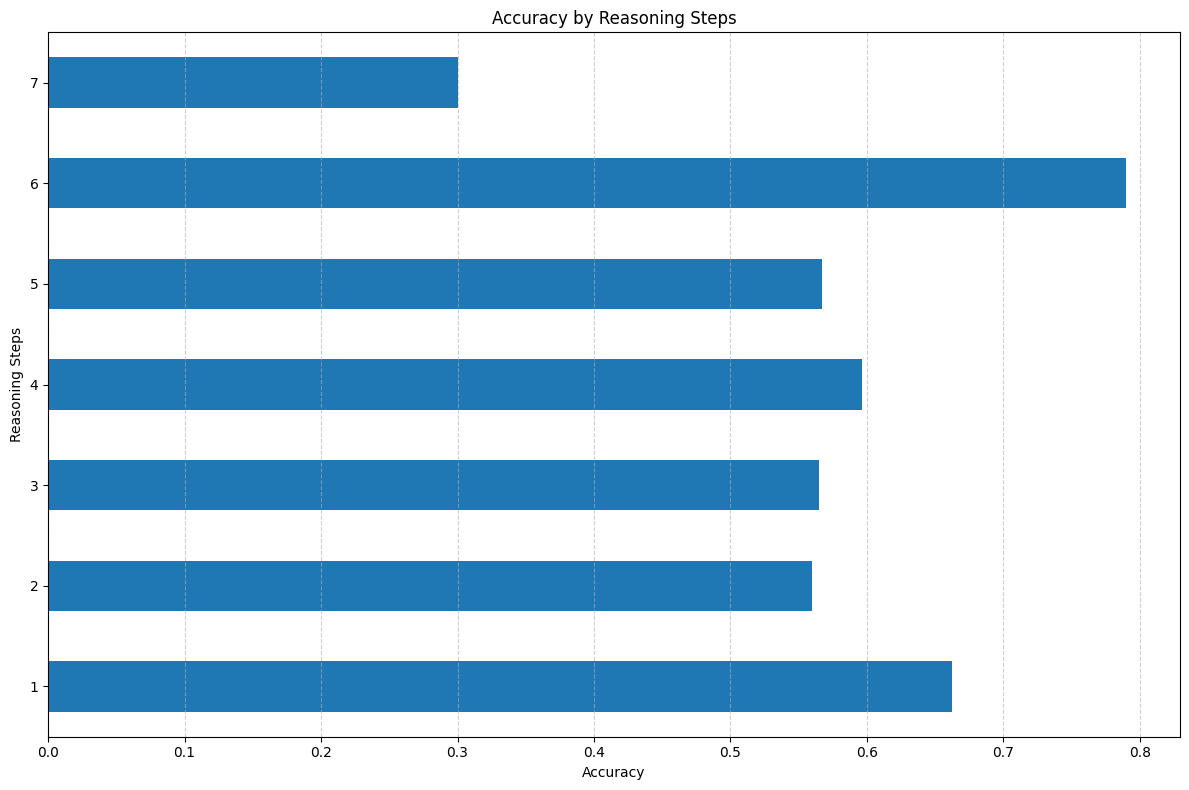

In [108]:
reasoing_steps_accuracy = result_df_2.groupby('reasoning_steps').apply(accuracy)
# Print the accuracies
print("reasoning steps-wise Accuracies:")
print(reasoing_steps_accuracy)

# Optional: Create a horizontal bar plot for better readability
plt.figure(figsize=(12, 8))
reasoing_steps_accuracy.plot(kind='barh')
plt.title('Accuracy by Reasoning Steps')
plt.xlabel('Accuracy')
plt.ylabel('Reasoning Steps')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()